In [105]:
from qiskit.circuit.library import EfficientSU2

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

from algo.utils import expectation_loss_grad

import numpy as np
import math
import matplotlib.pyplot as plt

In [106]:
def circuit_EfficientSU2(num_q: int, layer: int):
    num_p = (2*num_q) + (2*num_q) * layer
    theta = ParameterVector("θ", num_p)
    circ = EfficientSU2(num_q, reps=layer)
    return circ, theta

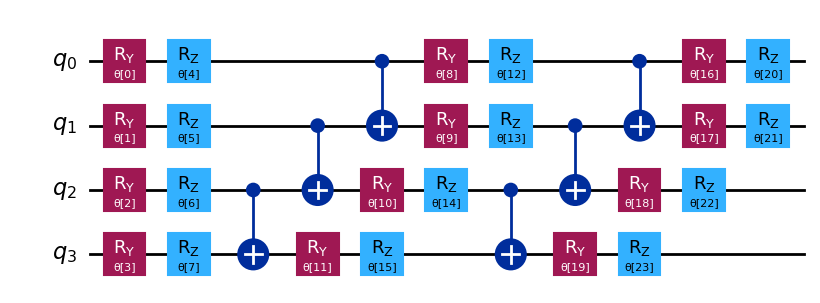

In [107]:
qc = EfficientSU2(4, reps=2)
qc.decompose().draw("mpl")

In [108]:
# global
num_q, layer = 3, 2
num_p = (2*num_q) + (2*num_q) * layer 
weights = np.random.uniform(0, 2*np.pi, size=num_p)

In [109]:
def ZY_ham(num_q):
    pauli_list = []
    if num_q == 1:
        raise ValueError("num_q must be greater than 1 for single qubit TFIM model")
    elif num_q == 2:
        pauli_list.append(('ZY', 1.0))
    else:
        label = ['I'] * num_q
        label[0] = 'Z'
        label[1] = 'Y'
        pauli_list.append((''.join(label), 1.0))

    return SparsePauliOp.from_list(pauli_list)

ZY_obs = ZY_ham(num_q)
print(ZY_obs)

SparsePauliOp(['ZYI'],
              coeffs=[1.+0.j])


In [110]:

expval = expectation_loss_grad(num_q,
                               layer,
                               weights,
                               circuit=circuit_EfficientSU2,
                               obs=ZY_obs,
                               )
print(expval)

0.09274901257776724


In [111]:
qubits = range(2, 13)
num_samples = 100
# layer_factor = 2

In [112]:
def Z_ham(num_q):
    pauli_list = []
    if num_q == 1:
        raise ValueError("num_q must be greater than 1 for single qubit TFIM model")
    elif num_q == 2:
        pauli_list.append(('ZI', 1.0))
    else:
        label = ['I'] * num_q
        label[0] = 'Z'
        # label[1] = 'Y'
        pauli_list.append((''.join(label), 1.0))

    return SparsePauliOp.from_list(pauli_list)

def Zn_ham(num_q):
    pauli_list = []
    if num_q == 1:
        raise ValueError("num_q must be greater than 1 for single qubit TFIM model")
    elif num_q == 2:
        pauli_list.append(('ZZ', 1.0))
    else:
        label = ['Z'] * num_q
        pauli_list.append((''.join(label), 1.0))

    return SparsePauliOp.from_list(pauli_list)

def Xn_ham(num_q, factor=0.25):
    pauli_list = []
    if num_q == 1:
        raise ValueError("num_q must be greater than 1 for single qubit TFIM model")
    else:
        pos = math.ceil(num_q*factor)
        label = ['X'] * pos + ['I'] * (num_q-pos)
        pauli_list.append((''.join(label), 1.0))

    return SparsePauliOp.from_list(pauli_list)

def MIX_ham(num_q):
    pauli_list = []
    if num_q == 1:
        raise ValueError("num_q must be greater than 1 for single qubit TFIM model")
    elif num_q == 2:
        pauli_list.append(('ZZ', 1.0))
        pauli_list.append(('ZI', 1.0))
    else:
        label = ['Z'] * num_q
        pauli_list.append((''.join(label), 5.0))
        label = ['I'] * num_q
        label[0] = 'Z'
        # label[1] = 'Y'
        pauli_list.append((''.join(label), 1.0))

    return SparsePauliOp.from_list(pauli_list)

# for num_q in qubits:
#     print(MIX_ham(num_q))

In [113]:
expval_means = []
expval_variances = []
ham = Zn_ham
# ham = lambda num_q: Xn_ham(num_q, factor=1)
# ham = Z_ham
ham = MIX_ham


for num_q in qubits:
    fun_vals = []
    layer = math.ceil(np.log(num_q)) # 向上取整
    num_p = (2*num_q) + (2*num_q) * layer
    obs = ham(num_q)

    for i in range(num_samples):
        weights = np.random.uniform(0, 2*np.pi, size=num_p)
        expval = expectation_loss_grad(num_q,
                                    layer,
                                    weights,
                                    circuit=circuit_EfficientSU2,
                                    obs=obs,
                                    )
        fun_vals.append(expval)

    expval_means.append(np.mean(fun_vals))
    expval_variances.append(np.var(fun_vals))

print(expval_means)
print(expval_variances)




[-0.10515563537807181, -0.40813528066433497, -0.006369934049154455, -0.11072807009401274, -0.06490109367103045, -0.04045593419668374, -0.0003834412445384128, 0.027226867935160715, 0.04044613347514585, 0.03214698555443685, 0.045898611531445116]
[0.40358843719838433, 2.945304536148857, 1.3490776883105002, 1.2293326021924684, 0.8039030069594493, 0.4581907751318716, 0.27026875478951157, 0.1894081461153414, 0.1332716732211554, 0.10988353221684921, 0.11782379824134319]


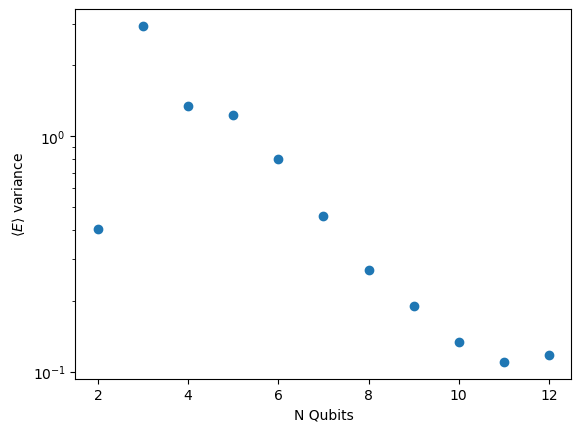

In [114]:
expval_variances = np.array(expval_variances)
nqubits = np.array(qubits)

# Fit the semilog plot to a straight line
# p = np.polyfit(qubits, np.log(variances), 1)

# Plot the straight line fit to the semilog
plt.semilogy(nqubits, expval_variances, "o")
# plt.semilogy(qubits, np.exp(p[0] * qubits + p[1]), "o-.", label="Slope {:3.2f}".format(p[0]))
plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle E\rangle$ variance")
# plt.legend()
plt.show()
